In [1]:
import pandas as pd
import csv
import re
import warnings
import time 
warnings.filterwarnings('ignore')
begin_start = time.time()

In [2]:
file = "big_df_v2.csv"  #large file for production
#file = "small_R_df.csv"       #small file for development
df = pd.read_csv('private/'+file, delimiter='|', encoding='latin-1')

In [3]:
#### stripping HTML tags ####
p = '<.*?>'
for col in df.columns:
    df[col] = df[col].replace(p, '', regex=True)

In [4]:
# splitting categories into main and sub, dropping non-Book main categories #
regex = r"\/(.*?)\/.*"

df['sub_cat'] = df['categoryPath'].str.extract(regex) # sub categories, one level below Books.
df['main_cat'] = df['categoryPath'].astype(str).str[:5] 
df = df[df.main_cat == 'Books'] #dropping non-Book categories

# drop rows missing critical data #
df = df.dropna(axis=0, how='any', subset=['longDn', 'sub_cat','name'])
df.isnull().sum().sort_values(ascending=False)

model           247144
parentItemId      3974
itemId            3515
shortDn            204
main_cat             0
sub_cat              0
catNode              0
longDn               0
categoryPath         0
name                 0
dtype: int64

In [5]:
print("There are " + str(len(df.sub_cat.value_counts())) + " categories of books.")
counts = df['sub_cat'].value_counts()
threshold = 100
print(str(len(counts[counts>threshold])) + " categories have more than " + str(threshold) +" books.")

There are 74 categories of books.
56 categories have more than 100 books.


In [6]:
Top_40_cats = df.sub_cat.value_counts().iloc[:39].index.tolist()

#df.sub_cat.value_counts().iloc[30:40]
print(df.sub_cat.value_counts().iloc[:39])


Business & Money Books                      20783
Children's & Kids' Books                    19813
Medical Books                               19255
History Books                               16745
Education Books                             14129
Computers & Technology Books                12787
Law Books                                   11642
Biographies & Memoirs                       10261
Sports & Outdoor Books                      10054
Political Books                              9292
Language Arts & Disciplines Books            7501
Self-Help Books                              7103
Health & Wellness Books                      6852
Crafts & Hobbies Books                       6475
Mathematics Books                            6388
Philosophy Books                             6114
Travel Books                                 5810
Reference Books                              5681
Foreign Language Study & Reference Books     5561
Teen & Young Adult Books                     5358


In [7]:
# Only keep records for top n populated categories (drop sparsely populated categories)
df = df.loc[df['sub_cat'].isin(Top_40_cats)]

In [8]:
df.sub_cat.value_counts().tail(n=30)

Political Books                             9292
Language Arts & Disciplines Books           7501
Self-Help Books                             7103
Health & Wellness Books                     6852
Crafts & Hobbies Books                      6475
Mathematics Books                           6388
Philosophy Books                            6114
Travel Books                                5810
Reference Books                             5681
Foreign Language Study & Reference Books    5561
Teen & Young Adult Books                    5358
Cookbooks, Food & Wine                      5031
Comic Books & Graphic Novels                4710
Study Aids & Test Prep Books                3848
Humor Books                                 3492
Literature & Fiction Books                  3203
Arts & Entertainment Books                  2588
Religion & Spirituality Books               2518
Psychology & Social Science Books           2371
Science & Nature Books                      1940
Libros en Espanol   

In [9]:
df.sub_cat.value_counts().iloc[:39].index.tolist()

#df.sub_cat.value_counts().iloc[30:40]
print(df.sub_cat.value_counts().iloc[:39])


Business & Money Books                      20783
Children's & Kids' Books                    19813
Medical Books                               19255
History Books                               16745
Education Books                             14129
Computers & Technology Books                12787
Law Books                                   11642
Biographies & Memoirs                       10261
Sports & Outdoor Books                      10054
Political Books                              9292
Language Arts & Disciplines Books            7501
Self-Help Books                              7103
Health & Wellness Books                      6852
Crafts & Hobbies Books                       6475
Mathematics Books                            6388
Philosophy Books                             6114
Travel Books                                 5810
Reference Books                              5681
Foreign Language Study & Reference Books     5561
Teen & Young Adult Books                     5358


In [12]:
#R_data_for_LDA = df
#R_data_for_LDA.to_csv('private/py_export_'+file, sep='|')

# Preparing Corpus and BOW for LDA Topic Modeling with Gensim
#### references used:
> http://mallet.cs.umass.edu/  
> https://radimrehurek.com/gensim/models/ldamodel.html  
> https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/  
> https://radimrehurek.com/gensim/models/wrappers/ldamallet.html

In [10]:
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

import nltk#; nltk.download('stopwords')
#!python3 -m spacy download en

In [11]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\decomposition\nmf.py:972: DeprecationWarning: invalid escape sequence \s
  """
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\decomposition\nmf.py:1186: DeprecationWarning: invalid escape sequence \s
  """
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\t_sne.py:420: DeprecationWarning: invalid escape sequence \s
  """


In [12]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['book'])

In [13]:
print(df.sub_cat.unique())

['Arts & Entertainment Books' "Children's & Kids' Books"
 'Business & Money Books' 'Cookbooks, Food & Wine'
 'Crafts & Hobbies Books' 'Literature & Fiction Books'
 'Religion & Spirituality Books' 'Dieting & Fitness Books'
 'Study Aids & Test Prep Books' 'Health & Wellness Books'
 'Biographies & Memoirs' 'Reference Books' 'Humor Books'
 'Libros en Espanol' 'Computers & Technology Books'
 'Comic Books & Graphic Novels' 'Teen & Young Adult Books' 'Medical Books'
 'Self-Help Books' 'History Books' 'True Crime Books'
 'Psychology & Social Science Books' 'House, Home & Gardening Books'
 'Travel Books' 'Education Books' 'Engineering & Transportation Books'
 'Science & Nature Books' 'Language Arts & Disciplines Books' 'Law Books'
 'Foreign Language Study & Reference Books' 'Mathematics Books'
 'Political Books' 'Philosophy Books' 'Sports & Outdoor Books'
 'Language Arts & Disciplines' 'Business & Money' 'Nonfiction' 'History'
 'Law']


In [14]:
data = df.longDn.values.tolist()

In [15]:
# converting contractions
data = [re.sub("won't","will not", sent) for sent in data]
data = [re.sub("can't","can not", sent) for sent in data]
data = [re.sub("n't","not", sent) for sent in data]
data = [re.sub("\'ll"," will", sent) for sent in data]
data = [re.sub("\'re"," are", sent) for sent in data]
data = [re.sub("\'ve"," have", sent) for sent in data]

# removing any single quotes
data = [re.sub("\'", " ", sent) for sent in data] 
# removing pipes to help with saving csv as pipe-delimited
data = [re.sub("\|", " ", sent) for sent in data]
# leave only letters and numbers (makes above lines redundant, but that's ok)
data = [re.sub("[^a-zA-Z0-9 ]", " ", sent) for sent in data]
# removing any extraneous spaces
data = [re.sub("\s+", " ", sent) for sent in data] #strip extra spaces

<input>:12: DeprecationWarning: invalid escape sequence \|
<input>:12: DeprecationWarning: invalid escape sequence \|
<input>:12: DeprecationWarning: invalid escape sequence \|
<input>:12: DeprecationWarning: invalid escape sequence \|
<input>:12: DeprecationWarning: invalid escape sequence \|
<input>:12: DeprecationWarning: invalid escape sequence \|
<input>:12: DeprecationWarning: invalid escape sequence \|
<input>:12: DeprecationWarning: invalid escape sequence \|
<input>:12: DeprecationWarning: invalid escape sequence \|
<input>:12: DeprecationWarning: invalid escape sequence \|
<input>:12: DeprecationWarning: invalid escape sequence \|
<input>:12: DeprecationWarning: invalid escape sequence \|
<input>:12: DeprecationWarning: invalid escape sequence \|
<input>:16: DeprecationWarning: invalid escape sequence \s
<input>:12: DeprecationWarning: invalid escape sequence \|
<input>:16: DeprecationWarning: invalid escape sequence \s
<input>:12: DeprecationWarning: invalid escape sequence 

In [19]:
data[300]

'Robust DC Comics Roster Engage in epic match ups with a massive roster of DC Comics heroes and villains including Batman Cyborg The Flash Harley Quinn Nightwing Solomon Grundy Superman and Wonder Woman Master God Like Powers Unleash each character s unique super powers with individual move sets and environmental interactions Uncontainable Battles Fight through multi tiered fighting arenas by hurling opponents through buildings and launching them off cliffs Original DC Comics Saga Set in Iconic Environments Experience an authentic DC Comics storyline created in collaboration between NetherRealm Studios DC Entertainment and writers Justin Gray and Jimmy Palmiotti Players will discover and do battle in numerous iconic locales pulled from DC Comics lore Destructive Fighter in which the World is a Weapon Experience epic battles on a massive scale as players control the most powerful beings in the universe in destructible interactive environments Destroy elements of the world and use super 

In [16]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

In [17]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=50) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
#print(trigram_mod[bigram_mod[data_words[4]]])

In [18]:
start = time.time()
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

end = time.time()
print(end-start)

0.0


In [19]:
start = time.time()
data_words_nostops = remove_stopwords(data_words)
data_words_bigrams = make_bigrams(data_words_nostops)
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

#print(data_lemmatized[:4])
end = time.time()
print(end-start)

C:\ProgramData\Anaconda3\lib\site-packages\msgpack_numpy.py:84: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  dtype=np.dtype(descr)).reshape(obj[b'shape'])
C:\ProgramData\Anaconda3\lib\site-packages\msgpack_numpy.py:88: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  dtype=np.dtype(descr))[0]
C:\ProgramData\Anaconda3\lib\site-packages\msgpack_numpy.py:84: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  dtype=np.dtype(descr)).reshape(obj[b'shape'])
C:\ProgramData\Anaconda3\lib\site-packages\msgpack_numpy.py:84: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  dtype=np.dtype(descr)).reshape(obj[b'shape'])
C:\ProgramData\Anaconda3\lib\site-pa

C:\ProgramData\Anaconda3\lib\site-packages\msgpack_numpy.py:84: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  dtype=np.dtype(descr)).reshape(obj[b'shape'])
C:\ProgramData\Anaconda3\lib\site-packages\msgpack_numpy.py:84: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  dtype=np.dtype(descr)).reshape(obj[b'shape'])


1569.4901711940765


In [20]:
start = time.time()

id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
end = time.time()
print(end-start)

29.23506736755371


# Attempt to improve model: consider 36 topics, chunksize of 15,000 docs, and 10 passes. 
> New Best Model  
> Runtime: 8 hours (482 minutes)   
> Perplexity: -8.75203  
> Coherence Score: 0.5877  

In [25]:
start = time.time()
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=36, 
                                           random_state=100,
                                           chunksize=15000,    # chunksize = number of docs to be used in each training chunk
                                           passes=10,
                                           per_word_topics=True)
end = time.time()
print(end-start)

# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)
end = time.time()
print(end-start)

28914.315784692764

Perplexity:  -8.752030310834112

Coherence Score:  0.5877747124377979
29310.143305301666


In [28]:
start = time.time()
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)

end = time.time()
print(end-start)
print(end - begin_start)
vis

588.1710016727448
49286.862916231155


PreparedData(topic_coordinates=           Freq  cluster  topics         x         y
topic                                               
0      9.959318        1       1 -0.264412  0.090133
10     9.767268        1       2 -0.265750 -0.180464
22     9.334954        1       3 -0.236952 -0.066973
8      7.855976        1       4 -0.202852  0.240583
12     5.867829        1       5 -0.190527  0.181623
34     5.380202        1       6 -0.169908  0.067412
4      4.844575        1       7 -0.171227  0.236196
35     4.534748        1       8 -0.183310  0.019927
28     4.503187        1       9 -0.171696 -0.213099
33     3.685816        1      10 -0.185927 -0.148230
14     3.242874        1      11 -0.106530 -0.151787
3      3.031913        1      12 -0.119793  0.086445
20     2.430606        1      13 -0.148760 -0.099535
2      2.381443        1      14 -0.100292  0.017826
11     2.225587        1      15 -0.123473 -0.195233
18     2.080099        1      16  0.151414 -0.003582
23     1.732229        1      17  0.167174 -0.024576
32     1.729389        1      18  0.005799  0.113993
27     1.631717        1      19  0.027605 -0.079309
9      1.501430        1      20  0.024797  0.072756
1      1.319514        1      21  0.058336  0.135363
7      1.300533        1      22  0.085730  0.012795
16     1.173252        1      23  0.041791 -0.067482
5      1.115481        1      24 -0.046320 -0.001992
29     0.858715        1      25  0.128857 -0.035229
31     0.845300        1      26  0.193552 -0.005426
21     0.785988        1      27  0.124756 -0.004920
13     0.763394        1      28  0.135528  0.070931
6      0.591155        1      29  0.172437  0.000813
15     0.586620        1      30  0.173326 -0.013745
25     0.530832        1      31  0.189246  0.014294
19     0.519933        1      32  0.206344 -0.013234
26     0.495068        1      33  0.184518 -0.019409
17     0.477057        1      34  0.206495 -0.010496
30     0.460620        1      35  0.209115 -0.013685
24     0.455378        1      36  0.200909 -0.012685, topic_info=       Category          Freq            Term         Total  loglift  logprob
term                                                                         
586     Default  47933.000000            work  47933.000000  30.0000  30.0000
861     Default  22309.000000        business  22309.000000  29.0000  29.0000
376     Default  27482.000000         student  27482.000000  28.0000  28.0000
713     Default  36136.000000           learn  36136.000000  27.0000  27.0000
556     Default  19883.000000        question  19883.000000  26.0000  26.0000
775     Default  35798.000000           story  35798.000000  25.0000  25.0000
155     Default  58193.000000            life  58193.000000  24.0000  24.0000
11      Default  18360.000000         edition  18360.000000  23.0000  23.0000
849     Default  15089.000000            test  15089.000000  22.0000  22.0000
828     Default  24307.000000        practice  24307.000000  21.0000  21.0000
76      Default  39897.000000           guide  39897.000000  20.0000  20.0000
845     Default  21167.000000           study  21167.000000  19.0000  19.0000
10026   Default  13313.000000             und  13313.000000  18.0000  18.0000
84      Default  16086.000000        language  16086.000000  17.0000  17.0000
128     Default  47016.000000             use  47016.000000  16.0000  16.0000
595     Default  19101.000000           child  19101.000000  15.0000  15.0000
1539    Default  14241.000000             die  14241.000000  14.0000  14.0000
77      Default  38292.000000            help  38292.000000  13.0000  13.0000
10022   Default  11870.000000             der  11870.000000  12.0000  12.0000
2573    Default  16471.000000           state  16471.000000  11.0000  11.0000
389     Default  21882.000000            book  21882.000000  10.0000  10.0000
1821    Default  17056.000000          system  17056.000000   9.0000   9.0000
82      Default  52952.000000         include  52952.000000   8.0000   

# Reducing to 30 topics, 100 random state, 20k chunksize, 10 passes
> New Best Model  
> Runtime: 1 hour (4015 seconds)   
> Perplexity: -8.72211  
> Coherence Score: 0.59769  

In [21]:
start = time.time()
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=30, 
                                           random_state=100,
                                           chunksize=20000,    # chunksize = number of docs to be used in each training chunk
                                           passes=10,
                                           per_word_topics=True)
end = time.time()
print(end-start)

# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)
end = time.time()
print(end-start)


1309.310468673706

Perplexity:  -8.722111545231282

Coherence Score:  0.5976930253548496
1600.4367415904999


In [22]:
start = time.time()
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)

end = time.time()
print(end-start)
print(end - begin_start)
vis

C:\ProgramData\Anaconda3\lib\site-packages\numexpr\cpuinfo.py:109: DeprecationWarning: invalid escape sequence \d
  nbits = re.compile('(\d+)bit').search(abits).group(1)
C:\ProgramData\Anaconda3\lib\site-packages\numexpr\cpuinfo.py:662: DeprecationWarning: invalid escape sequence \s
  "\s+stepping\s+(?P<STP>\d+)", re.IGNORECASE)


327.7855496406555
4015.2271943092346


PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
8      11.741936        1       1  0.221999 -0.151370
10     10.210301        1       2  0.237669  0.188287
22      9.037219        1       3  0.206073  0.139462
12      6.849471        1       4  0.162473 -0.123095
20      5.515045        1       5  0.184043  0.008381
17      4.788888        1       6  0.204389 -0.021570
26      4.216516        1       7  0.143924  0.197893
1       4.090124        1       8  0.120129 -0.193727
3       4.084490        1       9  0.104780 -0.101143
11      3.918915        1      10  0.132191  0.127963
16      3.715898        1      11  0.103547  0.148619
4       3.132652        1      12  0.078967 -0.217825
29      3.100972        1      13  0.085658 -0.011108
28      2.698072        1      14  0.051554  0.216340
0       2.665417        1      15  0.071309 -0.211335
13      2.449529        1      16  0.055024 -0.018548
23      2.198347        1      17 -0.207132  0.032232
7       2.044050        1      18 -0.202540  0.016796
18      1.993312        1      19 -0.041620 -0.204309
14      1.933266        1      20 -0.042820  0.029231
2       1.924712        1      21 -0.080679  0.057304
9       1.463874        1      22 -0.078252 -0.017192
27      1.409413        1      23 -0.088798  0.021188
5       1.005454        1      24 -0.066134  0.048961
6       0.780128        1      25 -0.230792 -0.025717
21      0.734579        1      26 -0.163355 -0.005447
25      0.635307        1      27 -0.228698  0.029408
15      0.625364        1      28 -0.233338  0.022492
19      0.543660        1      29 -0.246873  0.005390
24      0.493083        1      30 -0.252699  0.012437, topic_info=      Category          Freq           Term         Total  loglift  logprob
term                                                                       
586    Default  46797.000000           work  46797.000000  30.0000  30.0000
861    Default  21109.000000       business  21109.000000  29.0000  29.0000
155    Default  56465.000000           life  56465.000000  28.0000  28.0000
376    Default  26025.000000        student  26025.000000  27.0000  27.0000
11     Default  18941.000000        edition  18941.000000  26.0000  26.0000
775    Default  35174.000000          story  35174.000000  25.0000  25.0000
243    Default  31149.000000            get  31149.000000  24.0000  24.0000
713    Default  36438.000000          learn  36438.000000  23.0000  23.0000
10026  Default  13367.000000            und  13367.000000  22.0000  22.0000
1539   Default  14118.000000            die  14118.000000  21.0000  21.0000
1030   Default  15511.000000          woman  15511.000000  20.0000  20.0000
2573   Default  16636.000000          state  16636.000000  19.0000  19.0000
675    Default  30635.000000          write  30635.000000  18.0000  18.0000
697    Default  11944.000000           food  11944.000000  17.0000  17.0000
828    Default  25060.000000       practice  25060.000000  16.0000  16.0000
849    Default  17373.000000           test  17373.000000  15.0000  15.0000
10022  Default  11894.000000            der  11894.000000  14.0000  14.0000
76     Default  42141.000000          guide  42141.000000  13.0000  13.0000
556    Default  21978.000000       question  21978.000000  12.0000  12.0000
349    Default  51734.000000           make  51734.000000  11.0000  11.0000
845    Default  23286.000000          study  23286.000000  10.0000  10.0000
82     Default  53374.000000        include  53374.000000   9.0000   9.0000
526    Default  24760.000000        history  24760.000000   8.0000   8.0000
649    Default   8654.000000        journal   8654.000000   7.0000   7.0000
77     Default  38541.000000           help  38541.000000   6.0000   6.0000
389    Default  21701.000000           book  21701.000000   5.0000   5.0000
144    Default  31490.000000           find  31490.000000   4.0000   4.0000
84     Default  15948.000

# Attempting new high score: Topics: 30, chunks: 50k, passes=20

> New Best Model  
> Runtime: 1 hour (3439 seconds)   
> Perplexity: -8.6129  
> Coherence Score: 0.6238  

In [28]:
start = time.time()
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=30, 
                                           random_state=100,
                                           chunksize=50000,    # chunksize = number of docs to be used in each training chunk
                                           passes=20,
                                           per_word_topics=True)
end = time.time()
print(end-start)

# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)
end = time.time()
print(end-start)

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)

end = time.time()
print(end-start)
vis

2529.4696159362793

Perplexity:  -8.612855951277107

Coherence Score:  0.6238443153837738
2786.3836903572083
3059.431625366211


PreparedData(topic_coordinates=           Freq  cluster  topics         x         y
topic                                               
8      7.682620        1       1  0.126162  0.239113
3      7.388878        1       2  0.165959  0.150445
22     7.111084        1       3  0.146858 -0.090109
10     6.815186        1       4  0.182992 -0.100506
12     5.872808        1       5  0.087727  0.151839
0      4.238932        1       6  0.149670  0.073922
16     4.234859        1       7  0.189327 -0.006779
28     4.019387        1       8  0.157192 -0.134620
11     3.931979        1       9  0.051643  0.005187
27     3.791888        1      10  0.098213 -0.186942
1      3.734640        1      11  0.034762  0.192058
17     3.716907        1      12  0.129531 -0.079662
26     3.531607        1      13  0.129676 -0.221151
4      3.527565        1      14  0.047120  0.227218
29     3.164878        1      15  0.053542 -0.013633
20     3.153921        1      16  0.127904 -0.009411
9      3.033213        1      17  0.059124  0.169573
7      3.004684        1      18 -0.249167 -0.016576
14     2.919939        1      19  0.052432 -0.238921
19     2.470753        1      20 -0.054485  0.203573
5      2.171161        1      21  0.061425 -0.008270
13     2.068492        1      22  0.077294 -0.140900
6      1.657809        1      23 -0.139351 -0.017488
23     1.454538        1      24 -0.272762 -0.032133
24     1.449684        1      25 -0.269949 -0.026736
25     1.173729        1      26 -0.169214 -0.036334
21     0.926008        1      27 -0.184771 -0.025649
15     0.716696        1      28 -0.205380 -0.002906
18     0.556126        1      29 -0.299445 -0.017824
2      0.480039        1      30 -0.284028 -0.006379, topic_info=       Category          Freq                 Term         Total  loglift  \
term                                                                        
586     Default  46352.000000                 work  46352.000000  30.0000   
376     Default  28361.000000              student  28361.000000  29.0000   
1696    Default  12906.000000                  law  12906.000000  28.0000   
76      Default  41097.000000                guide  41097.000000  27.0000   
556     Default  19509.000000             question  19509.000000  26.0000   
861     Default  23034.000000             business  23034.000000  25.0000   
11      Default  18729.000000              edition  18729.000000  24.0000   
155     Default  52982.000000                 life  52982.000000  23.0000   
595     Default  23170.000000                child  23170.000000  22.0000   
849     Default  13914.000000                 test  13914.000000  21.0000   
713     Default  35834.000000                learn  35834.000000  20.0000   
10026   Default  13146.000000                  und  13146.000000  19.0000   
526     Default  25582.000000              history  25582.000000  18.0000   
775     Default  33754.000000                story  33754.000000  17.0000   
84      Default  16522.000000             language  16522.000000  16.0000   
828     Default  24008.000000             practice  24008.000000  15.0000   
697     Default  11491.000000                 food  11491.000000  14.0000   
10022   Default  11942.000000                  der  11942.000000  13.0000   
673     Default  15074.000000                 word  15074.000000  12.0000   
389     Default  20830.000000                 book  20830.000000  11.0000   
845     Default  20941.000000                study  20941.000000  10.0000   
82      Default  54174.000000              include  54174.000000   9.0000   
1539    Default  13996.000000                  die  13996.000000   8.0000   
728     Default   8863.000000               recipe   8863.000000   7.0000   
128     Default  47977.000000                  use  47977.000000   6.0000   
169     Default  16252.000000               school  16252.000000   5.0000   
1231    Default  15822.000000                 part  15822.000000   4.0000   
77      Default  38704.00000

# Attempting new high score: Topics: 30, chunks: 35, passes=35

> New Best Model?  
> Runtime:      
> Perplexity:    
> Coherence Score:  

In [27]:
start = time.time()
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=30, 
                                           random_state=100,
                                           chunksize=35000,    # chunksize = number of docs to be used in each training chunk
                                           passes=35,
                                           per_word_topics=True)
end = time.time()
print(end-start)

# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)
end = time.time()
print(end-start)

start = time.time()
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)

end = time.time()
print(end-start)
vis

3442.113005399704

Perplexity:  -8.671670944002065

Coherence Score:  0.562499034663562
3688.8340122699738
279.92552185058594


PreparedData(topic_coordinates=           Freq  cluster  topics         x         y
topic                                               
10     9.755023        1       1  0.225022 -0.103189
22     8.067950        1       2  0.176769 -0.079570
12     7.515685        1       3  0.145032  0.187209
0      6.524502        1       4  0.164038  0.140581
1      5.559953        1       5  0.124849  0.217121
17     5.497061        1       6  0.179311  0.086714
3      4.540558        1       7  0.093029  0.154230
27     4.524009        1       8  0.147101 -0.202277
8      4.444564        1       9  0.110235  0.254337
16     3.995384        1      10  0.160556 -0.052763
14     3.991405        1      11  0.128359 -0.232688
26     3.831290        1      12  0.157008 -0.203885
20     3.746266        1      13  0.172650 -0.105339
29     3.666068        1      14  0.127173 -0.057472
11     3.484769        1      15  0.117168 -0.031018
4      3.265968        1      16  0.069885  0.120481
7      2.974658        1      17 -0.184868 -0.015298
9      2.512213        1      18  0.054986  0.129235
23     2.317129        1      19 -0.206899 -0.024931
28     2.302036        1      20  0.037438 -0.161099
13     1.315048        1      21 -0.128637  0.081604
21     1.246221        1      22 -0.058317  0.015280
5      1.100085        1      23 -0.072993 -0.019202
25     0.635060        1      24 -0.227435 -0.022895
15     0.592400        1      25 -0.231733 -0.035423
6      0.580622        1      26 -0.255306 -0.007611
19     0.562275        1      27 -0.249296  0.002381
18     0.501585        1      28 -0.253754 -0.000428
24     0.484279        1      29 -0.265350 -0.018662
2      0.465934        1      30 -0.256020 -0.015423, topic_info=       Category          Freq                 Term         Total  loglift  \
term                                                                        
586     Default  45357.000000                 work  45357.000000  30.0000   
376     Default  27085.000000              student  27085.000000  29.0000   
76      Default  40543.000000                guide  40543.000000  28.0000   
155     Default  53830.000000                 life  53830.000000  27.0000   
713     Default  35928.000000                learn  35928.000000  26.0000   
10026   Default  14699.000000                  und  14699.000000  25.0000   
84      Default  19117.000000             language  19117.000000  24.0000   
11      Default  17761.000000              edition  17761.000000  23.0000   
861     Default  22418.000000             business  22418.000000  22.0000   
10022   Default  13225.000000                  der  13225.000000  21.0000   
775     Default  35702.000000                story  35702.000000  20.0000   
1539    Default  15389.000000                  die  15389.000000  19.0000   
649     Default  12148.000000              journal  12148.000000  18.0000   
169     Default  15260.000000               school  15260.000000  17.0000   
675     Default  32187.000000                write  32187.000000  16.0000   
82      Default  53837.000000              include  53837.000000  15.0000   
595     Default  21648.000000                child  21648.000000  14.0000   
556     Default  19523.000000             question  19523.000000  13.0000   
128     Default  48537.000000                  use  48537.000000  12.0000   
828     Default  23669.000000             practice  23669.000000  11.0000   
849     Default  14390.000000                 test  14390.000000  10.0000   
198     Default  14375.000000                 page  14375.000000   9.0000   
845     Default  21825.000000                study  21825.000000   8.0000   
673     Default  15906.000000                 word  15906.000000   7.0000   
77      Default  38081.000000                 help  38081.000000   6.0000   
526     Default  24330.000000              history  24330.000000   5.0000   
1696    Default  12680.000000                  law  12680.000000   4.0000   
243     Default  28149.00000

# Begin LDA Model

## 2nd best model: LdaModel, 40 topic, 100 random state, 5k chunksize, 2 passes, per_word True

In [29]:

start = time.time()
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=40, 
                                           random_state=100,
                                           #update_every=1,   # update_every = how often the model should be updated 
                                           chunksize=5000,    # chunksize = number of docs to be used in each training chunk
                                           passes=2,
                                           #alpha='auto',
                                           per_word_topics=True)
end = time.time()
print(end-start)


560.8973016738892


In [30]:
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(17,
  '0.020*"smith" + 0.019*"film" + 0.011*"chris" + 0.010*"library" + '
  '0.009*"bob" + 0.009*"co" + 0.008*"franchise" + 0.007*"mafia" + '
  '0.006*"contract" + 0.006*"industry"'),
 (7,
  '0.042*"state" + 0.028*"imperfection" + 0.021*"may" + 0.020*"edition" + '
  '0.019*"find" + 0.019*"rare" + 0.018*"thousand" + 0.018*"original" + '
  '0.018*"preserve" + 0.018*"com"'),
 (3,
  '0.015*"henry" + 0.012*"mike" + 0.009*"senator" + 0.007*"church" + '
  '0.006*"clark" + 0.006*"islamic" + 0.005*"devil" + 0.005*"religion" + '
  '0.005*"robinson" + 0.005*"democracy"'),
 (26,
  '0.030*"horse" + 0.019*"organisation" + 0.018*"record" + 0.016*"fly" + '
  '0.016*"flight" + 0.013*"transcript" + 0.010*"batman" + '
  '0.009*"supporting_pleading" + 0.009*"plane" + 0.008*"iran"'),
 (35,
  '0.035*"art" + 0.021*"artist" + 0.017*"image" + 0.013*"world" + '
  '0.011*"include" + 0.011*"color" + 0.010*"creative" + 0.009*"photograph" + '
  '0.009*"feature" + 0.008*"museum"'),
 (27,
  '0.027*"internet" + 0.02

In [31]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -9.144236970300915

Coherence Score:  0.5233064511402594


In [32]:
start = time.time()
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)

end = time.time()
print(end-start)
print(end - begin_start)
vis

528.8142590522766
52513.00148510933


PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
22     13.797095        1       1  0.236567  0.215899
0      12.125206        1       2  0.312384 -0.029592
10     11.925964        1       3  0.263144  0.210530
12      8.159432        1       4  0.273681 -0.059214
36      6.289633        1       5  0.237334 -0.004183
20      3.196590        1       6  0.183003  0.069701
4       3.155582        1       7  0.196103 -0.210625
14      3.117388        1       8  0.099443  0.249014
35      2.744359        1       9  0.135066  0.001444
8       2.590106        1      10  0.177397 -0.191233
34      2.401799        1      11  0.077947 -0.011569
33      2.283575        1      12  0.139866 -0.051358
23      2.129698        1      13 -0.139899  0.035266
30      2.004023        1      14 -0.130361  0.024240
13      1.930263        1      15  0.062388 -0.029534
5       1.741840        1      16  0.052529  0.142833
19      1.456333        1      17  0.068675 -0.175126
29      1.324548        1      18  0.041410  0.033331
7       1.302207        1      19 -0.048751  0.014764
37      1.244767        1      20 -0.055517  0.126091
18      1.216519        1      21 -0.016595 -0.110364
38      1.160945        1      22  0.032609 -0.161262
16      1.139387        1      23 -0.118706  0.056717
1       1.036233        1      24  0.019784 -0.144077
32      0.984680        1      25 -0.043635  0.072355
11      0.940951        1      26 -0.102834 -0.033230
9       0.774060        1      27 -0.102413  0.016655
25      0.732013        1      28 -0.081020 -0.109828
28      0.714813        1      29 -0.108164  0.092297
3       0.689275        1      30 -0.121771 -0.032215
17      0.669172        1      31 -0.103329 -0.001802
15      0.660962        1      32 -0.154749  0.016578
6       0.653498        1      33 -0.179213  0.020312
27      0.620789        1      34 -0.129787  0.008324
2       0.611006        1      35 -0.118062 -0.067693
39      0.564199        1      36 -0.138302  0.009983
31      0.519177        1      37 -0.170175 -0.006543
26      0.490543        1      38 -0.171920 -0.009037
21      0.471014        1      39 -0.183325  0.004677
24      0.430358        1      40 -0.190804  0.017478, topic_info=       Category          Freq              Term         Total  loglift  \
term                                                                     
586     Default  48563.000000              work  48563.000000  30.0000   
376     Default  24694.000000           student  24694.000000  29.0000   
775     Default  42326.000000             story  42326.000000  28.0000   
84      Default  17320.000000          language  17320.000000  27.0000   
155     Default  62566.000000              life  62566.000000  26.0000   
828     Default  24788.000000          practice  24788.000000  25.0000   
556     Default  20543.000000          question  20543.000000  24.0000   
595     Default  18717.000000             child  18717.000000  23.0000   
845     Default  22697.000000             study  22697.000000  22.0000   
1821    Default  17514.000000            system  17514.000000  21.0000   
10026   Default  13418.000000               und  13418.000000  20.0000   
649     Default  12105.000000           journal  12105.000000  19.0000   
713     Default  34847.000000             learn  34847.000000  18.0000   
389     Default  22583.000000              book  22583.000000  17.0000   
675     Default  32913.000000             write  32913.000000  16.0000   
191     Default   9961.000000              game   9961.000000  15.0000   
1539    Default  14459.000000               die  14459.000000  14.0000   
849     Default  17896.000000              test  17896.000000  13.0000   
2573    Default  15200.000000             state  15200.000000  12.0000   
76      Default  39409.000000             guide  39409.000000  11.0000   
526     Default  22957.000000           history  22957.000000

# Begin LDA Multicore Model  
## initial results: lower coherence score but processes twice as fast

In [33]:
start = time.time()

lda_multicore_model = gensim.models.ldamulticore.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           workers=3,
                                           num_topics=40, 
                                           random_state=100,
                                           eval_every=1,   # update_every = how often the model should be updated 
                                           chunksize=5000,  # chunksize = number of docs to be used in each training chunk
                                           passes=2,        # passes = total number of training passes
                                           #alpha='auto',
                                           per_word_topics=True)
end = time.time()
print(end-start)

296.70015954971313


In [34]:
pprint(lda_multicore_model.print_topics())
doc_lda = lda_multicore_model[corpus]

[(26,
  '0.013*"math" + 0.010*"record" + 0.009*"transcript" + 0.008*"grade" + '
  '0.007*"common_core" + 0.006*"supporting_pleading" + 0.005*"standard" + '
  '0.005*"dementia" + 0.004*"curriculum" + 0.004*"school"'),
 (10,
  '0.014*"business" + 0.012*"use" + 0.011*"guide" + 0.008*"step" + '
  '0.008*"make" + 0.007*"learn" + 0.007*"need" + 0.007*"new" + 0.006*"help" + '
  '0.006*"work"'),
 (19,
  '0.006*"et" + 0.004*"test_taker" + 0.004*"film" + 0.004*"elle" + 0.004*"che" '
  '+ 0.003*"pour" + 0.003*"histoire" + 0.003*"ce" + 0.003*"macroeconomic" + '
  '0.003*"sont"'),
 (25,
  '0.018*"horse" + 0.011*"paperback" + 0.010*"insurance" + 0.007*"bitcoin" + '
  '0.005*"security" + 0.004*"isbn" + 0.004*"house" + 0.004*"trust" + '
  '0.004*"include" + 0.004*"information"'),
 (32,
  '0.014*"part" + 0.012*"publish" + 0.010*"may" + 0.010*"imperfection" + '
  '0.009*"work" + 0.009*"print" + 0.008*"introduce" + 0.008*"believe" + '
  '0.008*"american" + 0.008*"reproduction"'),
 (8,
  '0.009*"game" + 0

In [35]:
start = time.time()
# Compute Perplexity
print('\nPerplexity: ', lda_multicore_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_multicore_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)
end = time.time()
print(end-start)


Perplexity:  -8.778841353983674

Coherence Score:  0.4873685981012084
462.90783500671387


In [36]:
pprint(lda_multicore_model.print_topics())
doc_lda = lda_multicore_model[corpus]

[(2,
  '0.053*"sport" + 0.014*"training" + 0.014*"athlete" + 0.010*"player" + '
  '0.008*"soccer" + 0.008*"baseball" + 0.007*"world" + 0.006*"coach" + '
  '0.006*"fan" + 0.006*"game"'),
 (31,
  '0.012*"application" + 0.007*"batman" + 0.006*"bible" + 0.006*"new" + '
  '0.006*"code" + 0.006*"datum" + 0.006*"language" + 0.005*"sale" + '
  '0.005*"programming" + 0.004*"algorithm"'),
 (20,
  '0.014*"get" + 0.014*"learn" + 0.012*"read" + 0.012*"make" + 0.011*"child" + '
  '0.009*"help" + 0.008*"time" + 0.008*"good" + 0.008*"book" + 0.007*"want"'),
 (0,
  '0.027*"life" + 0.010*"get" + 0.009*"love" + 0.009*"find" + 0.008*"make" + '
  '0.007*"way" + 0.007*"know" + 0.007*"write" + 0.007*"go" + 0.006*"want"'),
 (33,
  '0.013*"comic" + 0.013*"yoga" + 0.013*"hardcover" + 0.008*"golf" + '
  '0.006*"series" + 0.005*"feature" + 0.005*"new" + 0.005*"child" + '
  '0.005*"include" + 0.005*"first"'),
 (14,
  '0.028*"clinical" + 0.025*"food" + 0.021*"patient" + 0.014*"disease" + '
  '0.011*"treatment" + 0.

In [37]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_multicore_model, corpus, id2word)
vis

PreparedData(topic_coordinates=           Freq  cluster  topics         x         y
topic                                               
22     9.618005        1       1  0.109239 -0.134416
10     9.362097        1       2  0.139335 -0.152984
37     7.220650        1       3  0.089534 -0.236677
36     6.903533        1       4  0.108677  0.158007
12     6.433626        1       5  0.150302  0.044085
0      5.501395        1       6  0.156360  0.072468
8      4.180880        1       7  0.109189  0.167874
4      3.936148        1       8  0.112348  0.183766
34     3.819865        1       9  0.080979  0.049748
16     3.465747        1      10  0.109687 -0.117554
3      3.390823        1      11  0.101909  0.106817
20     3.217976        1      12  0.128584 -0.050646
7      3.108139        1      13 -0.277905  0.000195
39     3.002519        1      14  0.077273 -0.151907
1      2.476578        1      15  0.069020  0.168222
23     2.110767        1      16 -0.359160 -0.022292
13     1.982450        1      17  0.042775  0.030065
29     1.915695        1      18  0.023162 -0.003443
38     1.541777        1      19  0.049443  0.072010
14     1.460603        1      20  0.015893 -0.161659
17     1.416101        1      21  0.084838 -0.034287
35     1.272276        1      22 -0.001966  0.018541
2      1.110377        1      23  0.035577  0.015743
28     1.096230        1      24  0.054427 -0.075799
32     1.017237        1      25 -0.023744  0.021280
31     0.988878        1      26 -0.081918 -0.086160
27     0.827118        1      27 -0.041719 -0.142450
11     0.803550        1      28 -0.004905 -0.031246
33     0.709292        1      29  0.002805  0.012160
18     0.679050        1      30 -0.042800  0.169465
5      0.661209        1      31 -0.056280 -0.003192
25     0.633800        1      32 -0.018001 -0.042035
9      0.592657        1      33 -0.025491  0.057067
26     0.536363        1      34 -0.057963 -0.089536
6      0.535724        1      35 -0.212359  0.007761
30     0.533815        1      36 -0.071307  0.054911
15     0.517437        1      37 -0.165731  0.002340
19     0.503099        1      38 -0.194094  0.080017
21     0.493662        1      39 -0.071320  0.024210
24     0.422859        1      40 -0.144691  0.019532, topic_info=      Category          Freq          Term         Total  loglift  logprob
term                                                                      
586    Default  45891.000000          work  45891.000000  30.0000  30.0000
10026  Default  14293.000000           und  14293.000000  29.0000  29.0000
10022  Default  12838.000000           der  12838.000000  28.0000  28.0000
376    Default  26588.000000       student  26588.000000  27.0000  27.0000
1539   Default  15259.000000           die  15259.000000  26.0000  26.0000
2894   Default  10050.000000         sport  10050.000000  25.0000  25.0000
595    Default  19589.000000         child  19589.000000  24.0000  24.0000
84     Default  16967.000000      language  16967.000000  23.0000  23.0000
155    Default  59442.000000          life  59442.000000  22.0000  22.0000
82     Default  52779.000000       include  52779.000000  21.0000  21.0000
703    Default  12009.000000        health  12009.000000  20.0000  20.0000
649    Default  13366.000000       journal  13366.000000  19.0000  19.0000
76     Default  40065.000000         guide  40065.000000  18.0000  18.0000
526    Default  23722.000000       history  23722.000000  17.0000  17.0000
673    Default  15829.000000          word  15829.000000  16.0000  16.0000
713    Default  35003.000000         learn  35003.000000  15.0000  15.0000
2425   Default   7523.000000            la   7523.000000  14.0000  14.0000
132    Default  45642.000000         world  45642.000000  13.0000  13.0000
828    Default  24905.000000      practice  24905.000000  12.0000  12.0000
775    Default  35073.000000         story  35073.000000  11.0000  11.0000
1231   Default  14946.000000          part  14946.000000  10.0000  10.0000
128   

# LDA Multicore model approach #2, fewer categories  
## Initial Result: No improvement.

In [38]:
start = time.time()
lda_model_2 = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=30, 
                                           random_state=100,
                                           eval_every=1,      # update_every = how often the model should be updated 
                                           chunksize=10000,    # chunksize = number of docs to be used in each training chunk
                                           passes=2,
                                           per_word_topics=True)
end = time.time()
print(end-start)

208.51714754104614


In [39]:
# Compute Perplexity
print('\nPerplexity: ', lda_model_2.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model_2, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.991759137108872

Coherence Score:  0.4200400745759138


In [40]:
start = time.time()
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model_2, corpus, id2word)

end = time.time()
print(end-start)
vis

449.26842761039734


PreparedData(topic_coordinates=           Freq  cluster  topics         x         y
topic                                               
1      8.683796        1       1 -0.004102  0.126211
22     8.398088        1       2  0.039298 -0.031886
12     8.248659        1       3  0.030433  0.043349
28     7.416761        1       4  0.065444 -0.090883
10     7.194577        1       5  0.055826 -0.048042
3      5.998231        1       6  0.023121  0.046246
17     5.949640        1       7  0.044940  0.001525
4      5.879297        1       8 -0.000461  0.124308
27     3.768679        1       9  0.018820 -0.089680
7      3.313036        1      10 -0.346888 -0.039897
9      3.137999        1      11  0.008577  0.071791
23     2.799010        1      12 -0.031766 -0.130712
13     2.493104        1      13  0.032216 -0.017212
20     2.229821        1      14  0.010815  0.002447
15     2.166175        1      15  0.026539 -0.024656
29     1.975405        1      16  0.009711 -0.016500
19     1.904519        1      17 -0.013781  0.078805
0      1.895702        1      18  0.025900  0.006843
16     1.863884        1      19  0.014225  0.021299
8      1.782212        1      20 -0.033373  0.057072
6      1.767625        1      21 -0.017699 -0.001744
18     1.562499        1      22 -0.028464  0.088712
5      1.551374        1      23  0.022659  0.000172
25     1.438302        1      24  0.027382 -0.030994
14     1.381868        1      25  0.017654 -0.045587
24     1.231329        1      26  0.013578 -0.044602
11     1.062542        1      27  0.015281 -0.004842
26     1.015073        1      28  0.021305 -0.032542
21     0.987633        1      29 -0.019688 -0.009174
2      0.903153        1      30 -0.027499 -0.009828, topic_info=      Category          Freq       Term         Total  loglift  logprob
term                                                                   
10026  Default  13434.000000        und  13434.000000  30.0000  30.0000
10022  Default  12163.000000        der  12163.000000  29.0000  29.0000
1539   Default  13957.000000        die  13957.000000  28.0000  28.0000
586    Default  46161.000000       work  46161.000000  27.0000  27.0000
82     Default  52684.000000    include  52684.000000  26.0000  26.0000
128    Default  49407.000000        use  49407.000000  25.0000  25.0000
376    Default  30265.000000    student  30265.000000  24.0000  24.0000
713    Default  37197.000000      learn  37197.000000  23.0000  23.0000
76     Default  38956.000000      guide  38956.000000  22.0000  22.0000
22     Default  56728.000000        new  56728.000000  21.0000  21.0000
349    Default  54331.000000       make  54331.000000  20.0000  20.0000
155    Default  55696.000000       life  55696.000000  19.0000  19.0000
595    Default  26317.000000      child  26317.000000  18.0000  18.0000
775    Default  37915.000000      story  37915.000000  17.0000  17.0000
77     Default  38909.000000       help  38909.000000  16.0000  16.0000
84     Default  15984.000000   language  15984.000000  15.0000  15.0000
849    Default  12124.000000       test  12124.000000  14.0000  14.0000
828    Default  23095.000000   practice  23095.000000  13.0000  13.0000
3653   Default   7223.000000       exam   7223.000000  12.0000  12.0000
556    Default  17578.000000   question  17578.000000  11.0000  11.0000
132    Default  45992.000000      world  45992.000000  10.0000  10.0000
673    Default  13437.000000       word  13437.000000   9.0000   9.0000
2425   Default   6546.000000         la   6546.000000   8.0000   8.0000
845    Default  20092.000000      study  20092.000000   7.0000   7.0000
724    Default  33272.000000    provide  33272.000000   6.0000   6.0000
861    Default  24954.000000   business  24954.000000   5.0000   5.0000
697    Default  10351.000000       food  10351.000000   4.0000   4.0000
121    Default  44131.000000       time  44131.000000   3.0000   3.0000
169    Default  17124.000000     school  17124.000000   2.0000   2.0000
351    Default  17236.000000 

# How many topics should we train? 

In [41]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=20, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA multiecore models
    coherence_values : Coherence values corresponding to the LDA multicore model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamulticore.LdaMulticore(corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values


"""    
    Warning: This WILL take a while 
"""
start_time = time.time()
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=30, limit=45, step=3)

end = time.time()
print(end-start_time)



1072.0016548633575


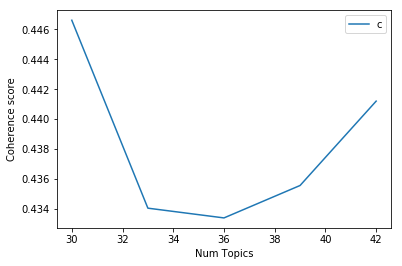

Num Topics = 30  has Coherence Value of 0.4466
Num Topics = 33  has Coherence Value of 0.4341
Num Topics = 36  has Coherence Value of 0.4334
Num Topics = 39  has Coherence Value of 0.4356
Num Topics = 42  has Coherence Value of 0.4412
1072.3761587142944


In [42]:
# Show graph
limit=45; start=30; step=3;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

end = time.time()
print(end-start_time)

In [43]:
############################################################
# comparing LDA model coherence scores vs. LDA Multicore
############################################################
#  As expected (and unexplained) LDA Model performs better
#  than the LDA multicore model with identical parameters 
############################################################


def compute_coherence_values(dictionary, corpus, texts, limit, start=20, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

"""    
    Warning: This WILL take a while 
"""
start_time = time.time()
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=30, limit=45, step=3)

end = time.time()
print(end-start_time)



2722.557155609131


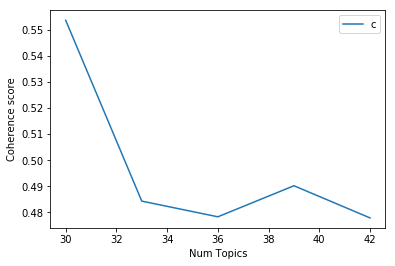

Num Topics = 30  has Coherence Value of 0.5535
Num Topics = 33  has Coherence Value of 0.4843
Num Topics = 36  has Coherence Value of 0.4783
Num Topics = 39  has Coherence Value of 0.4902
Num Topics = 42  has Coherence Value of 0.4779
2723.0563249588013


In [44]:
# Show graph
limit=45; start=30; step=3;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

end = time.time()
print(end-start_time)

#          LDA Multicore results:   
big_df  
>  Num Topics = 30  has Coherence Value of 0.4437  
>  Num Topics = 33  has Coherence Value of 0.4106  
>  Num Topics = 36  has Coherence Value of 0.4513  
>  Num Topics = 39  has Coherence Value of 0.4462  
>  Num Topics = 42  has Coherence Value of 0.4425   

bigger_df: 18 minutes  
> Num Topics = 30  has Coherence Value of 0.4466  
> Num Topics = 33  has Coherence Value of 0.4341  
> Num Topics = 36  has Coherence Value of 0.4334  
> Num Topics = 39  has Coherence Value of 0.4356  
> Num Topics = 42  has Coherence Value of 0.4412  

#            LDA Model results:   
big_df  
> Num Topics = 30  has Coherence Value of 0.5116  
> Num Topics = 33  has Coherence Value of 0.5101  
> Num Topics = 36  has Coherence Value of 0.5146  
> Num Topics = 39  has Coherence Value of 0.4696  
>  Num Topics = 42  has Coherence Value of 0.4832  
 
bigger_df:  45 minutes
> Num Topics = 30  has Coherence Value of 0.5535
> Num Topics = 33  has Coherence Value of 0.4843
> Num Topics = 36  has Coherence Value of 0.4783
> Num Topics = 39  has Coherence Value of 0.4902
> Num Topics = 42  has Coherence Value of 0.4779
      
  As expected (and unexplained) LDA Model performs better  
  than the LDA multicore model with identical parameters   



In [45]:
- intentional fail to prevent subsequent code to run -
fail.

SyntaxError: invalid syntax (<ipython-input-45-76a76cdb656f>, line 1)

# Begin LDA Mallet
### troubleshooting:
> https://searchcode.com/codesearch/view/92751630/ - code  
> https://github.com/RaRe-Technologies/gensim/issues/818 - bug identified?   

In [ ]:
from gensim.models.wrappers import LdaMallet

In [ ]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
#mallet_path = 'mallet-2.0.8/bin/mallet' 

In [ ]:
ldamallet = gensim.models.wrappers.ldamallet.LdaMallet('mallet_2.0.8/bin/mallet', corpus=corpus, num_topics=40, id2word=id2word, workers=3)

In [ ]:
#redo of LDA model

start = time.time()
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=40, 
                                           random_state=100,
                                           #update_every=1,   # update_every = how often the model should be updated 
                                           chunksize=5000,    # chunksize = number of docs to be used in each training chunk
                                           passes=2,
                                           #alpha='auto',
                                           per_word_topics=True)


pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)

end = time.time()
print(end-start)
vis

In [ ]:
#redo of LDA multicore model. Should be same as above

start = time.time()
lda_model = gensim.models.ldamulticore.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=40, 
                                           random_state=100,
                                           #update_every=1,   # update_every = how often the model should be updated 
                                           chunksize=5000,    # chunksize = number of docs to be used in each training chunk
                                           passes=2,
                                           #alpha='auto',
                                           per_word_topics=True)


pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)

end = time.time()
print(end-start)
vis